# COUNTRY LABEL PROPAGATION

**Aim :** Propagate a country label over a graph.  
**Notation :**
- G : simple graph
- G_url_labels : G with country labels from URL domain (or 'Not classify' if not known)

# LIBRARIES

In [1]:
import os
import os.path
os.chdir("C:/Users/maell/Fake_News_Project")

import urllib.request
import zipfile

import pandas as pd
import numpy as np
import community

from scipy import *

from itertools import combinations
from collections import Counter

import matplotlib.pyplot as plt

import networkx as nx

# METHODS

## 0- Prepare Graph
To create G_url_labels if we only have G

In [2]:
def classification_géographique_url(G):
    G_url_labels=G.copy()
    for source in graph.nodes():
        if source.endswith(".au"):
            G_url_labels.node[source]['URL']='Australia'
            G_url_labels.node[source]['Country']='Australia'
        elif source.endswith(".uk"):
            G_url_labels.node[source]['URL']='UK'
            G_url_labels.node[source]['Country']='UK'
        elif source.endswith(".in"):
            G_url_labels.node[source]['URL']='India'
            G_url_labels.node[source]['Country']='India'
        elif source.endswith(".nz"):
            G_url_labels.node[source]['URL']='New Zealand'
            G_url_labels.node[source]['Country']='New Zealand'
        elif source.endswith(".org"):
            G_url_labels.node[source]['URL']='Organization'
            G_url_labels.node[source]['Country']='Organization'
        elif source.endswith(".us"):
            G_url_labels.node[source]['URL']='USA'
            G_url_labels.node[source]['Country']='USA'
        elif source.endswith(".international"):
            G_url_labels.node[source]['URL']='International'
            G_url_labels.node[source]['Country']='International'
        elif source.endswith(".zm"):
            G_url_labels.node[source]['URL']='Zambia'
            G_url_labels.node[source]['Country']='Zambia'
        elif source.endswith(".ca"):
            G_url_labels.node[source]['URL']='Canada'
            G_url_labels.node[source]['Country']='Canada'
        elif source.endswith(".za"):
            G_url_labels.node[source]['URL']='South Africa'
            G_url_labels.node[source]['Country']='South Africa'
        else:
            G_url_labels.node[source]['URL']='Not Classified'
    return(G_url_labels)

## 1- Create Referency

From two referencies :
- URL domain
- CSV file from ABYZ News Links

In [3]:
def create_country_reference(G):
    #Récupération des dataframes de référence
    countries = pd.read_csv('source_country.csv',sep = ';',decimal = '.')
    url = dataframe_url(G)
    
    #Création d'un dataframe de référence unique
    countries=countries[['WebsiteURL','Country']]
    countries.set_index('WebsiteURL',inplace=True)
    url.set_index('WebsiteURL',inplace=True)

    reference= url.join(countries)
    reference= reference[~reference.index.duplicated(keep='first')] #On supprime les lignes multiples
    reference= reference.fillna(value='Not Classified') #On remplace NaN par 'Not Classified'

    #Mise à zéro du nombre de différences
    diff_url_csv=0

    # Mise en forme du dataframe de reference
    for index,row in reference.iterrows():
        ligne=reference.loc[index]
        if ligne.Country=='Not Classified':
            ligne.Country=ligne.URL
        if ligne.Country!='Not Classified'  and ligne.URL!=ligne.Country:
            diff_url_csv+=1
        
    #supprier la colone url
    reference.drop('URL',1)

    #Print
    print('Nombre de sites ayant un pays issus de l\'URL différent de celui issu du CSV :',diff_url_csv)
    
    return reference

################################################################################

def dataframe_url(G):
    dataframe=pd.DataFrame({'WebsiteURL':[], 'URL':[]},columns = ['WebsiteURL','URL'],index=[])
    for source in G.nodes():
        if source.endswith(".au"):
            url='Australia'
        elif source.endswith(".uk"):
             url='UK'
        elif source.endswith(".in"):
             url='India'
        elif source.endswith(".nz"):
             url='New Zealand'
        elif source.endswith(".org"):
             url='Organization'
        elif source.endswith(".us"):
             url='USA'
        elif source.endswith(".international"):
             url='International'
        elif source.endswith(".zm"):
             url='Zambia'
        elif source.endswith(".ca"):
             url='Canada'
        elif source.endswith(".za"):
             url='South Africa'
        else:
            url='Not Classified'
        dataframe = dataframe.append([{'WebsiteURL':source,'URL':url}], ignore_index=True)
    return dataframe

## 2- Propagate labels over the graph

In [4]:
def label_propagation_pays(G_url_labels,nodes_liste,reference):
    # Label propagation du label 'label' via le dataframe reference sur le graph 'G', pour les nodes de la liste nodes_liste
    
    compteur=0
    compteur_retry=0
    #Tant que l'on a pas traité tous les points ...
    while nodes_liste!=[]:
        
        #On tire un point au hasard
        number_nodes=len(nodes_liste)
        if number_nodes>1:
            webURL=nodes_liste[random.randint(0,number_nodes-1)];
        else:
            webURL=nodes_liste[0]
        node = G_url_labels.nodes[webURL]
        
        #On récupère les attributs
        country=reference.loc[webURL].Country
        
        #SI PAS DEJA UN PAYS :
        if country=='Not Classified' : #Si pas classifié
    
            #On récupère tout les voisins, et on leur attribue leur pays 
            voisins=dict(G_url_labels[webURL])
            data_voisins = pd.DataFrame.from_dict(voisins, orient='index')
            truc=data_voisins.join(reference)
            truc = truc.replace('Not Classified',np.nan)
        
            #On calcul le poids de chaque voisin
            tab=truc[['weight','Country']].groupby(['Country']).agg(['count'])

            #On récupère celui qui a le plus de poids
            weightCount_sort=tab.sort_values([('weight','count')],ascending=False)
            try:
                weightChoosenCountry=weightCount_sort.iloc[0][('weight','count')]
            except: #Si on a aucun pays en voisin
                weightChoosenCountry=-1
                
            #On calcul le poids total
            serie=pd.Series(truc.weight.values, index=truc.Country)
            sum_weight=serie.sum()
        
            #On vérifie que le poids relatif du pays choisi est assez important (min 0% ici)
            if (weightChoosenCountry/sum_weight)>0:
                #Si oui, on lui attribut son pays et on le retire de la liste à traiter
                ChoosenCountry=weightCount_sort.iloc[0].name
                node['Country']=ChoosenCountry #On attribut le node
                reference.loc[webURL].Country=ChoosenCountry #On attribut dans reference
                nodes_liste.remove(webURL)
                compteur=compteur+1
                print('Classified :',compteur)
                compteur_retry=0
            else:
                compteur_retry+=1
                print('Retry',compteur_retry)
                if compteur_retry>100:
                    return
        # SI DEJA UN PAYS : on le retire de la liste
        else:
            nodes_liste.remove(webURL)

## 3- Study the results

In [5]:
def plot_confusion_matrix(df_confusion, title='Confusion matrix', cmap=plt.cm.Reds):
    plt.matshow(df_confusion, cmap=cmap) # imshow
    #plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(df_confusion.columns))
    plt.xticks(tick_marks, df_confusion.columns, rotation=90)
    plt.yticks(tick_marks, df_confusion.index)
    #plt.tight_layout()
    plt.ylabel(df_confusion.index.name)
    plt.xlabel(df_confusion.columns.name)

# USE THE FUNCTIONS

## Label propagation on several days and take the most appearance label

In [ ]:
############################ PARAMETERS #######################################

list_days= ['20170830','20170930','20171030','20171130','20171230','20180130','20180227','20180330','20180412',
            '20180430','20180530','20180630','20180730','20180830','20180930']

############### CREATE THE DATAFRAME OF LABEL PROPAGATION RESULTS ##############

study_classification=pd.DataFrame()

for day in list_days:
    file='graph/graph_'+day+'.gexf'
    G_url_labels=nx.read_gexf(file) #the file need to have url labels
    
    #reference
    reference=create_country_reference(G)
    print('Reference Created')
    
    #Label Propagation
    sources=[x for x,y in G.nodes(data=True) if y['URL']=='Not Classified']
    label_propagation_pays(G_url_labels,sources,reference)
    print('Label Propagation OK')
    
    #Injection in study_classification DataFrame
    dict_nodes=dict(G_url_labels.nodes(data=True))
    study_this_day=pd.DataFrame.from_dict(dict_nodes,orient='index')
    study_this_day=study_this_day[['Country']]
    study_this_day = study_this_day.rename(columns={'Country': day})

    
    #Merge with study_classification
    study_classification=pd.merge(study_classification, study_this_day,how='outer', right_index=True, left_index=True)

    print('OK '+file)

study_classification.to_csv('study_classification.csv', sep='\t', decimal= '.')

In [7]:
#################### STUDY THE DATAFRAME OF THE RESULTS #######################
study_classification = pd.read_csv('study_classification.csv',sep = '\t',decimal = '.',index_col=0)

list_c_country=[]
list_c_number=[]
list_confidence=[]
for index,row in study_classification.iterrows():
    ligne=study_classification.loc[index]
    columns=study_classification.columns
    liste=[]
    for i in range (len(study_classification.columns)):
        liste.append(ligne[i])
    c = Counter(liste)
    nb_nan=c[nan]
    if pd.isnull(c.most_common(1)[0][0]):                
        if c.most_common(1)[0][1]==len(study_classification.columns):
            list_c_country.append('Not Classified')
            list_c_number.append(0)
            list_confidence.append(0)
        else:
            list_c_country.append(c.most_common(2)[1][0])
            list_c_number.append(c.most_common(2)[1][1])
            list_confidence.append(c.most_common(2)[1][1]/(len(study_classification.columns)-nb_nan))
    else:
        list_c_country.append(c.most_common(1)[0][0])
        list_c_number.append(c.most_common(1)[0][1])
        list_confidence.append(c.most_common(1)[0][1]/(len(study_classification.columns)-nb_nan))
        
study_classification['Most appearance country'] =list_c_country
study_classification['Nb of appearance'] =list_c_number
study_classification['Confidence'] =list_confidence

########################## PRINT THE RESULTS ##################################
print('Nombre moyen d\'apparition : ',mean(study_classification['Nb of appearance']))
print('Confiance moyenne : ',mean(study_classification['Confidence']))
study_classification.head()

Nombre moyen d'apparition :  3.715181843811672
Confiance moyenne :  0.7441197859403469


,20170830,20170930,20171030,20171130,20171230,20180130,20180227,20180330,20180412,20180430,20180530,20180630,20180730,20180830,20180930,Most appearance country,Nb of appearance,Confidence
1005freshradio.ca,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Canada,Canada,Canada,Canada,Canada,Canada,Canada,Canada,Canada,8,1.000000
1009theeagle.com,Organization,UK,USA,Australia,India,USA,USA,Organization,USA,UK,UK,NaN,NaN,NaN,NaN,USA,4,0.363636
100milefreepress.net,Canada,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Canada,NaN,NaN,Canada,2,1.000000
1011now.com,USA,UK,UK,UK,UK,USA,USA,UK,USA,UK,UK,UK,UK,UK,UK,UK,11,0.733333
1013online.com,USA,USA,UK,USA,USA,Organization,NaN,USA,USA,USA,UK,USA,UK,NaN,NaN,USA,8,0.666667


**Conclusion**  
- Each node is not always present in each graph. For this study, by observing 15 different days (graph), we found that the mean of the number of apperance is close to 4.
- This is why the number of appearance is not really showing how good the label propagation is. A better choice is to check the confidence : this number is the ratio between the number of appearance of the "choosen country" over the number of graph where this node is present. The mean of this indicator over all the nodes is close to 0.75 : it shows that the label propagation is quite stable over the graphs.

# Verification with the GDELT Master File

In [8]:
# loading GDELT master file
master = pd.read_csv('MASTER-GDELTDOMAINSBYCOUNTRY-MAY2018.TXT', delimiter="\t", names=['WebsiteURL','CountryCode','Country'])
master=master.set_index('WebsiteURL')

# creating verification dataframe
verification = study_classification[['Most appearance country']]
verification = verification.rename({'Most appearance country':'Found country'}, axis='columns')
verification = verification.join(master[['Country']], how='inner')

# modification for USA and UK
verification['Country'].replace(to_replace=['United States'],value='USA',inplace=True)
verification['Country'].replace(to_replace=['United Kingdom'],value='UK',inplace=True)

In [9]:
# print results
print('Number of well classified :',len(verification[verification['Found country']==verification['Country']]))
print('Number of bad classified :',len(verification[verification['Found country']!=verification['Country']]))
print('----------------------------')
found_countries=verification['Found country'].unique()
countries=verification['Country'].unique()
print('Nb of found countries :',len(found_countries))
print('Nb of real countries :',len(countries))
print('----------------------------')
print('Just for the 11 countries we know :')
verification_on_11=verification[verification['Country'].isin(found_countries)] #We keep only "our" countries
verification_on_11=verification_on_11[verification_on_11['Found country'].isin(verification_on_11['Country'].unique())]#on enlève international, not classified ect
print('Number of well classified :',len(verification_on_11[verification_on_11['Found country']==verification_on_11['Country']]))
print('Number of bad classified :',len(verification_on_11[verification_on_11['Found country']!=verification_on_11['Country']]))

Number of well classified : 4915
Number of bad classified : 8851
----------------------------
Nb of found countries : 11
Nb of real countries : 178
----------------------------
Just for the 11 countries we know :
Number of well classified : 4915
Number of bad classified : 5209


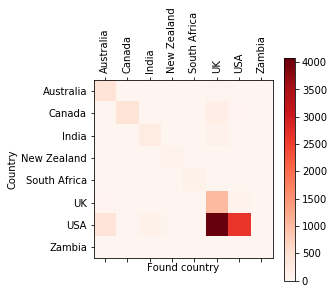

In [10]:
# plot confusion matrix
y_actual = verification_on_11['Country']
y_predicted = verification_on_11['Found country']
df_confusion = pd.crosstab(y_actual, y_predicted)
plot_confusion_matrix(df_confusion)

**Conclusion**  
- The diagonal presents higher levels than over possibilities. It shows that the label propagation provides a good level of true positives.
- There is a lot more of true positive for the USA than for other countries. It can be explained by the fact that our referencies have a lot more 'USA' labels (via the csv) than other countries.
- There is a lot of errors between USA and UK : quite a lot of USA are classified as UK. It can be explained by the fact that UK and USA are very connected (same subjects).
- One more thing to take into account is that our database is not containing a lot of countries

## Validation over the days (without most appearance label)

In [15]:
list_days=['20170830','20170930','20171030','20171130','20171230']

for day in list_days:

    file='graph/graph_'+day+'.gexf'
    G_url_labels=nx.read_gexf(file)

    # Test and Training set selection
    total_set=[x for x,y in G_url_labels.nodes(data=True) if y['URL']!='Not Classified'] #we take every node which is labelized
    train_set=[]
    test_set=[]

    reference_total_set=create_country_reference(G_url_labels)
    reference_train_set=pd.DataFrame.copy(reference_total_set)

    for i in range (0,len(total_set)):
        nb=np.random.randint(3)
        if nb==2:
            test_set.append(total_set[i])
            reference_train_set.drop([total_set[i]]) # TO BE CHECK
        else: #Ratio used : train_set=2/3 ; test_set=1/3
            train_set.append(total_set[i])


    # Label propagation
    test_set_bis=list.copy(test_set)
    label_propagation_pays(G_url_labels,test_set_bis,reference_train_set)

    # Label propagation evaluation
    bad_classified_nodes=[]
    well_classified_nodes=[]
    for test_node in test_set:
        ref=reference_total_set.loc[test_node].Country
        if G_url_labels.nodes[test_node]['Country']!=ref:
            bad_classified_nodes.append(test_node)
        else:
            well_classified_nodes.append(test_node)

    print(day)
    print('Nb of bad classified nodes : ',len(bad_classified_nodes))
    print('% of bad classified nodes : ', len(bad_classified_nodes)/len(test_set)) 
    print('Nb of well classified nodes : ',len(well_classified_nodes))
    print('% of well classified nodes : ', len(well_classified_nodes)/len(test_set)) 
    print('--------------------------------------------------------')

Nombre de sites ayant un pays issus de l'URL différent de celui issu du CSV : 134
20170830
Nb of bad classified nodes :  3
% of bad classified nodes :  0.007957559681697613
Nb of well classified nodes :  374
% of well classified nodes :  0.9920424403183024
--------------------------------------------------------
Nombre de sites ayant un pays issus de l'URL différent de celui issu du CSV : 104
20170930
Nb of bad classified nodes :  3
% of bad classified nodes :  0.015228426395939087
Nb of well classified nodes :  194
% of well classified nodes :  0.9847715736040609
--------------------------------------------------------
Nombre de sites ayant un pays issus de l'URL différent de celui issu du CSV : 133
20171030
Nb of bad classified nodes :  5
% of bad classified nodes :  0.01567398119122257
Nb of well classified nodes :  314
% of well classified nodes :  0.9843260188087775
--------------------------------------------------------
Nombre de sites ayant un pays issus de l'URL différent de c

**Conclusion** 
- The number of countries with label different for URL and CSV is mostly due to the "international" classification of the CSV file.
- There is always less than 2% error on the "simple" label propagation.
- We must stay carfull with this good result. In the complete graph there could be more error because in our test the nodes where we verify the labelization may be more connected to "known" sources than in the real complete graph.